In [24]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.optim as optim
import os
from skimage import io, transform
from skimage.measure import label as sklabel
import matplotlib.pyplot as plt
import tifffile as tiff
import numpy as np
from scipy import ndimage
from scipy.ndimage import zoom, map_coordinates, distance_transform_edt
import cv2

# Data exploration for EM Segmentation


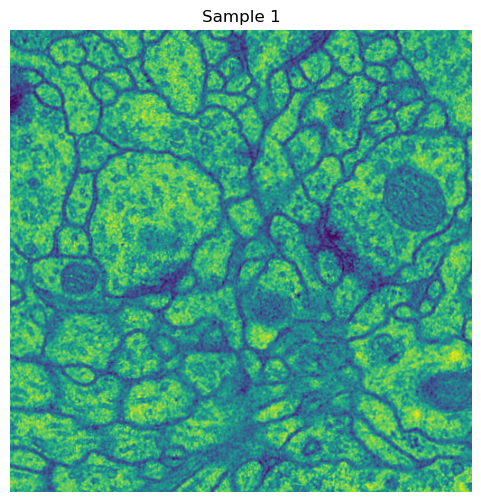

In [25]:
train_images_dir = "em-seg/train/imgs"
train_labels_dir = "em-seg/train/labels"

im_path = os.path.join(train_images_dir, "frame_0001.png")
img = io.imread(im_path, as_gray=True)
label_path = os.path.join(train_labels_dir, "frame_0001.png")
label = io.imread(label_path, as_gray=True)
plt.figure(figsize=(6, 6))  
plt.imshow(img) 
plt.title("Sample 1")
plt.axis('off')
plt.show()

In [26]:
print(img.shape)
print(type(img))
# One Image is 512x512 pixels
# Add a Resize operation to the data pipeline if needed ? 
# Number of images in the training set
train_image_files = os.listdir(train_images_dir)
print(f"Number of training images: {len(train_image_files)}")


(512, 512)
<class 'numpy.ndarray'>
Number of training images: 30


In [4]:
def download_data():
    data_dir = "em-seg/train"
    im_folder = os.path.join(data_dir, "imgs")
    label_folder = os.path.join(data_dir, "labels")    
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
        print(f"Data directory '{data_dir}' created. Please download the dataset manually.")
    else:
        print(f"Data directory '{data_dir}' already exists.")

## Data Augmentation through elastic deformation 

"Especially random elastic deformations of the training samples seem to be the key concept to train
a segmentation network with very few annotated images. We generate smooth
deformations using random displacement vectors on a coarse 3 by 3 grid. The
displacements are sampled from a Gaussian distribution with 10 pixels standard
deviation. Per-pixel displacements are then computed using bicubic interpola-
tion. "

In [27]:
def elastic_transform_paired(image, label, sigma=10, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)
    h, w = image.shape[:2]
    
    grid_size = 3
    grid_x = random_state.normal(0, sigma, size=(grid_size, grid_size))
    grid_y = random_state.normal(0, sigma, size=(grid_size, grid_size))

    yi = np.linspace(0, grid_size - 1, h)
    xi = np.linspace(0, grid_size - 1, w)
    xy_grid = np.meshgrid(yi, xi, indexing='ij')
    
    dx = ndimage.map_coordinates(grid_x, xy_grid, order=3, mode='reflect')
    dy = ndimage.map_coordinates(grid_y, xy_grid, order=3, mode='reflect')

    Y, X = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    indices = [Y + dy, X + dx]

    image_warped = ndimage.map_coordinates(
        image, indices, order=1, mode='reflect'
    )

    label_warped = ndimage.map_coordinates(
        label, indices, order=0, mode='reflect'
    )

    return image_warped, label_warped

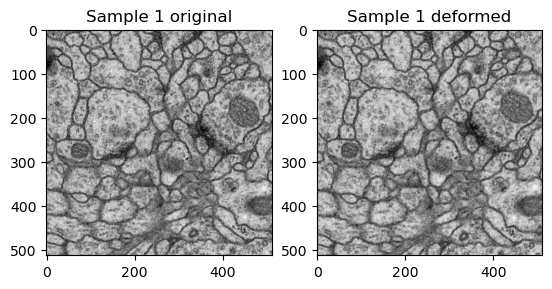

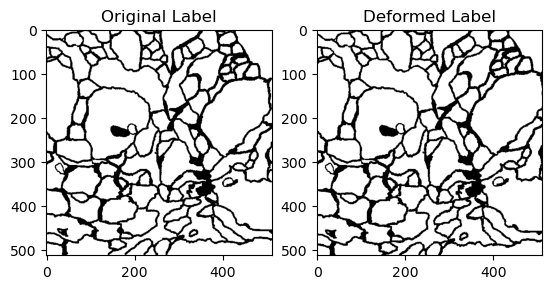

In [28]:
img_deformed, label_deformed = elastic_transform_paired(img, label)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img, cmap="gray")
axarr[0].set_title("Sample 1 original")
axarr[1].imshow(img_deformed, cmap="gray")
axarr[1].set_title("Sample 1 deformed")

f , axarr = plt.subplots(1,2)
axarr[0].imshow(label, cmap="gray")
axarr[0].set_title("Original Label")
axarr[1].imshow(label_deformed, cmap="gray")
axarr[1].set_title("Deformed Label")
plt.show()

Before creating the custom dataset let's compute the mean and std or all the 30 train_images, we will use that later in our data transformation pipeline

In [29]:
images = []
for filename in os.listdir(train_images_dir):
    if filename.endswith('.png'):
        img_path = os.path.join(train_images_dir, filename)
        img = io.imread(img_path, as_gray=True)
        images.append(img)

# Stack all images into a single array
dataset_array = np.stack(images) 

print(dataset_array.shape) 
data_float = dataset_array.astype(np.float32) / 255.0
mean = data_float.mean()
std = data_float.std()

print(f"Moyenne : {mean:.4f}")
print(f"Écart-type : {std:.4f}")

(30, 512, 512)
Moyenne : 0.4948
Écart-type : 0.1726


While creating the define_transform function we encouter a problem, our data augmentation is not a common transforms function and return a tuple, this will likely crash in the Compose pipeline, to adress this issue we will use a recent library that handle this situation

## first approach 

In [30]:
class ElasticTransformPaired:
    def __init__(self, sigma=10, p=0.5):
        self.sigma = sigma
        self.p = p

    def __call__(self, image, label):
        if torch.rand(1).item() > self.p:
            return image, label
        return elastic_transform_paired(image, label, sigma=self.sigma)

In [ ]:
def weight_map(label, w0=10.0, sigma=5.0, connectivity=2):
    mask = (label == 255)

    labelled = sklabel(mask, connectivity=connectivity)
    num_cells = labelled.max()

    wc = np.ones_like(mask, dtype=np.float32)

    # Handle case with 0 or 1 cell - no borders to weight
    if num_cells < 2:
        return wc

    distance_maps = []

    for k in range(1, num_cells + 1):
        cell = (labelled == k)
        dist = distance_transform_edt(~cell)
        distance_maps.append(dist)

    D = np.stack(distance_maps, axis=0)
    D_sorted = np.sort(D, axis=0)

    d1 = D_sorted[0]
    d2 = D_sorted[1]

    w = wc + w0 * np.exp(-((d1 + d2) ** 2) / (2 * sigma ** 2))

    return w.astype(np.float32)

In [31]:
class EMDataset(Dataset):
    def __init__(
        self,
        root_dir,
        split="train",
        paired_transform=None,
        mean=None,
        std=None,
        precompute_weights=True,
    ):
        self.root_dir = root_dir
        self.split = split
        self.paired_transform = paired_transform

        self.image_dir = os.path.join(root_dir, split, "imgs")
        self.label_dir = os.path.join(root_dir, split, "labels")

        self.fnames = sorted(
            f for f in os.listdir(self.image_dir)
            if f.endswith(".png")
        )

        self.normalize = (
            transforms.Normalize(mean, std) if mean is not None else None
        )
        
        # Pre-compute and cache weight maps
        self.weight_maps = {}
        if precompute_weights:
            print("Pre-computing weight maps...")
            for idx, fname in enumerate(self.fnames):
                label = self._load_label(fname)
                w_map = weight_map(label, w0=10.0, sigma=5.0)
                self.weight_maps[fname] = w_map
                if (idx + 1) % 10 == 0:
                    print(f"  Processed {idx + 1}/{len(self.fnames)} weight maps")
            print("Weight maps pre-computed and cached!")

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        fname = self.fnames[idx]

        image = self._load_image(fname)
        label = self._load_label(fname)

        if self.paired_transform is not None:
            image, label = self.paired_transform(image, label)

        image = torch.from_numpy(image).float().unsqueeze(0)
        label = torch.from_numpy(label).long()

        if self.normalize is not None:
            image = self.normalize(image)
        
        # Get pre-computed weight map
        w_map = self.weight_maps.get(fname)
        if w_map is None:
            # Fallback: compute on-the-fly if not cached
            w_map = weight_map(label.numpy(), w0=10.0, sigma=5.0)
        w_map = torch.from_numpy(w_map).float()

        return image, label, w_map

    def _load_image(self, fname):
        img = io.imread(os.path.join(self.image_dir, fname))
        if img.ndim == 3:
            img = img[..., 0]
        return img.astype(np.float32)

    def _load_label(self, fname):
        mask = io.imread(os.path.join(self.label_dir, fname))
        if mask.ndim == 3:
            mask = mask[..., 0]
        if mask.max() > 1:
            mask = (mask > 0).astype(np.uint8)
        return mask

"we favor large input tiles over a large batch size and hence reduce the batch to a single image" 
This imply batch_size = 1 

In [ ]:
paired_transform = ElasticTransformPaired(sigma=10)

root_path = "./em-seg"

train_set = EMDataset(
    root_dir=root_path,
    split="train",
    paired_transform=paired_transform,
    mean=mean,
    std=std,
)

batch_size = 1 #BatchSize   
# Note: num_workers=0 for Jupyter notebook compatibility
# The weight map pre-computation provides the main speed boost
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Set to 0 for Jupyter notebook compatibility
    pin_memory=True,  # Faster data transfer to MPS
)

In [ ]:
#Quick sanity check
x, y, w = train_set[0]
print(x.shape, x.dtype)  # (1, H, W), float32
print(y.shape, y.unique())  # (H, W), {0,1}
print(w.shape, w.dtype)  # (H, W), float32 (weight map)
fig, axes = plt.subplots(4, 3, figsize=(10, 12))

for i in range(4):
    image, mask, _ = train_set[i]

    img = image.squeeze(0).cpu().numpy()
    msk = mask.cpu().numpy()

    axes[i, 0].imshow(img, cmap="gray")
    axes[i, 0].set_title("Image")

    axes[i, 1].imshow(msk, cmap="gray")
    axes[i, 1].set_title("Mask")

    axes[i, 2].imshow(img, cmap="gray")
    axes[i, 2].imshow(msk, cmap="jet", alpha=0.4)
    axes[i, 2].set_title("Overlay")

    for j in range(3):
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()

## Network Architecture

Based on the repetitive architecture : 
"It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels." We create 

In [33]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 0), # 3x3 unpadded convolution
            nn.BatchNorm2d(out_channels), # Added for 
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

In [34]:
# Verify the CNNBlock
print("--- Verifying CNNBlock ---\n")
# Instantiate the block with 1 input channels and 16 output channels
verify_cnn_block = CNNBlock(in_channels=1, out_channels=64)
print("Block Structure:\n")
print(verify_cnn_block)

--- Verifying CNNBlock ---

Block Structure:

CNNBlock(
  (block): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
)


In [35]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):
        super(UNet, self).__init__()
        
        self.down1 = CNNBlock(in_channels, 64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.down2 = CNNBlock(64, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.down3 = CNNBlock(128, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.down4 = CNNBlock(256, 512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = CNNBlock(512, 1024)
        
        self.up_trans1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv1 = CNNBlock(1024, 512)
        
        self.up_trans2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv2 = CNNBlock(512, 256)
        
        self.up_trans3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv3 = CNNBlock(256, 128)
        
        self.up_trans4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv4 = CNNBlock(128, 64)
        
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.maxpool1(d1)
        
        d2 = self.down2(p1)
        p2 = self.maxpool2(d2)
        
        d3 = self.down3(p2)
        p3 = self.maxpool3(d3)
        
        d4 = self.down4(p3)
        p4 = self.maxpool4(d4)
        
        b = self.bottleneck(p4)
        
        u1 = self.up_trans1(b)
        if d4.shape != u1.shape:
            d4 = TF.center_crop(d4, [u1.shape[2], u1.shape[3]])
        u1 = torch.cat((d4, u1), dim=1)
        u1 = self.up_conv1(u1)
        
        u2 = self.up_trans2(u1)
        if d3.shape != u2.shape:
            d3 = TF.center_crop(d3, [u2.shape[2], u2.shape[3]])
        u2 = torch.cat((d3, u2), dim=1)
        u2 = self.up_conv2(u2)
        
        u3 = self.up_trans3(u2)
        if d2.shape != u3.shape:
            d2 = TF.center_crop(d2, [u3.shape[2], u3.shape[3]])
        u3 = torch.cat((d2, u3), dim=1)
        u3 = self.up_conv3(u3)
        
        u4 = self.up_trans4(u3)
        if d1.shape != u4.shape:
            d1 = TF.center_crop(d1, [u4.shape[2], u4.shape[3]])
        u4 = torch.cat((d1, u4), dim=1)
        u4 = self.up_conv4(u4)
        
        return self.final_conv(u4)

# Weight map

In [36]:
# Initiate the model

model = UNet()

def count_conv_layers(model):
    return sum(
        1 for m in model.modules()
        if isinstance(m, ( nn.Conv2d, nn.ConvTranspose2d))
    )

print(count_conv_layers(model))


23


We have our 23 layers of convolution as written in the article! For the training we need to instanciate our loss function, we can't use the CrossEntropyFunction(weight), weight do a manual rescaling weight given to each class or we want to do a manuel rescaling weight given to each pixel based on the distance to the border. Softmax + CrossEntropy weighted

In [38]:
import torch.nn.functional as F

def unet_loss(logits, target, weight):
    ce = F.cross_entropy(
        logits,
        target,
        reduction="none"
    )  # (N, H, W)

    # apply U-Net weight map
    loss = weight * ce

    return loss.mean()

In [19]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.99)

In [39]:
def train_epoch(model, train_loader, loss_function, optimizer, device):
    # Performs a single training epoch.
    model.train()
    running_loss = 0.0
    # Iterate over batches of data in the training loader
    for images, labels in train_loader:
        # Move images and labels to the specified device
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss


In [40]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            # Calculate N: kernel_size[0] * kernel_size[1] * in_channels
            n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
            # Standard deviation = sqrt(2/N)
            std = np.sqrt(2.0 / n)
            # Initialize weights from Gaussian distribution
            nn.init.normal_(m.weight, mean=0.0, std=std)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
    
    print("Model weights initialized according to U-Net paper specifications")
    print("Conv layers use Gaussian distribution with std = sqrt(2/N)")
    print("where N = kernel_height * kernel_width * in_channels")

## Training the Model

Now we'll train the model with proper weight initialization as described in the U-Net paper. The weights are initialized from a Gaussian distribution with standard deviation √(2/N), where N is the number of incoming connections (kernel_size × kernel_size × in_channels).

In [41]:
# Set device - MPS for MacBook Pro
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model with proper weight initialization
model = UNet(in_channels=1, num_classes=2)
initialize_weights(model)
model = model.to(device)

# Training parameters
num_epochs = 100
learning_rate = 0.01
momentum = 0.99

# Optimizer (SGD with high momentum as per paper)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Training loop
train_losses = []

print(f"\nStarting training for {num_epochs} epochs...")
print(f"Learning rate: {learning_rate}, Momentum: {momentum}")
print(f"Batch size: {batch_size}, Training samples: {len(train_set)}\n")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    # Use pre-computed weight maps from dataset
    for batch_idx, (images, labels, weight_maps) in enumerate(train_loader):
        # Move to device
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        weight_maps = weight_maps.to(device, non_blocking=True)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        
        # Crop labels and weight maps to match output size
        if outputs.shape[2:] != labels.shape[1:]:
            target_h, target_w = outputs.shape[2], outputs.shape[3]
            labels = TF.center_crop(labels.unsqueeze(1), [target_h, target_w]).squeeze(1)
            weight_maps = TF.center_crop(weight_maps.unsqueeze(1), [target_h, target_w]).squeeze(1)
        
        # Compute loss
        loss = unet_loss(outputs, labels, weight_maps)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("\nTraining completed!")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

Using device: mps
Model weights initialized according to U-Net paper specifications
Conv layers use Gaussian distribution with std = sqrt(2/N)
where N = kernel_height * kernel_width * in_channels

Starting training for 100 epochs...
Learning rate: 0.01, Momentum: 0.99
Batch size: 1, Training samples: 30



Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/debrion/miniconda3/envs/ml-dev/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/debrion/miniconda3/envs/ml-dev/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'EMDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 

In [ ]:
# Visualize predictions on a few training samples
model.eval()

fig, axes = plt.subplots(3, 4, figsize=(15, 12))

with torch.no_grad():
    for i in range(3):
        # Get a sample
        image, true_label, _ = train_set[i]
        image_batch = image.unsqueeze(0).to(device)
        
        # Get prediction
        output = model(image_batch)
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
        
        # Prepare image for display
        img_display = image.squeeze(0).cpu().numpy()
        
        # Crop true label to match prediction size
        if pred.shape != true_label.shape:
            true_label = TF.center_crop(
                true_label.unsqueeze(0).unsqueeze(0), 
                [pred.shape[0], pred.shape[1]]
            ).squeeze().numpy()
        else:
            true_label = true_label.cpu().numpy()
        
        # Plot: original image, ground truth, prediction, overlay
        axes[i, 0].imshow(img_display, cmap='gray')
        axes[i, 0].set_title(f'Sample {i+1}: Input Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(true_label, cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred, cmap='gray')
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')
        
        axes[i, 3].imshow(img_display, cmap='gray')
        axes[i, 3].imshow(pred, cmap='jet', alpha=0.4)
        axes[i, 3].set_title('Overlay')
        axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

print("\nModel output shape example:")
print(f"Input: {image.shape} → Output: {output.shape} → Prediction: {pred.shape}")